In [175]:
import shap
import torch
import numpy as np
from pathlib import Path
from agent import DQN
import random
import matplotlib.pyplot as plt

## Setting DQN Model

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
save_path = Path("save")
save_path.exists()

True

In [7]:
data_dir = save_path / "7-8-LR"
data_dir.exists()

True

In [8]:
data_path = data_dir / "data.tar"
data_path.exists()

True

In [9]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [10]:
parameters = data_dict['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [12]:
model = DQN(n_observations, n_actions, n_units)

Since the SHAP explainers work with NumPy arrays, not Tensors, we need a wrapper to convert the DQN input/output tensors to NumPy arrays for the explainers.

In [2]:
class WrappedModel:
    def __init__(self, model, device='cuda'):
        self.model = model.eval().to(device)  # eval mode and move to GPU
        self.device = device

    def __call__(self, inputs_numpy):
        # Convert NumPy → PyTorch tensor and move to GPU
        inputs_tensor = torch.tensor(inputs_numpy, dtype=torch.float32).to(self.device)

        # Forward pass (no gradients needed)
        with torch.no_grad():
            outputs_tensor = self.model(inputs_tensor)

        # Move output back to CPU and convert to NumPy
        return outputs_tensor.cpu().numpy()


In [13]:
# Loading Specific Agent Model
model_path = data_dir / f'trained-agent-state-0.pt'
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [15]:
wrapped_model = WrappedModel(model, device='cpu')

Now we need to reconstruct the replay buffer of the trained agent in order to sample states to use for the SHAP explainer. We want to get representative states.

In [49]:
all_states = data_dict['all_states']
print(all_states.shape)
agent_index = 0
print(all_states[agent_index].shape)
agent_eps = all_states[agent_index]

(100, 200)
(200,)


By manual inspection of the training log for the agent, you can see when the replay buffer ends (look for when loss stops being nan).

In [50]:
replay_buffer_idx = 81 # TODO: somehow manually automate this

replay_buffer_ep = agent_eps[:replay_buffer_idx]
replay_buffer_states = [state for episode in replay_buffer_ep for state in episode]
assert len(replay_buffer_states) > 5000

The background data is a representative sample of states we will feed to the SHAP explainer. The explainer will use these states for masking and determining feature importance.

In [51]:
background_data = random.sample(replay_buffer_states, k=100) # CONSIDER THE SAMPLING METHOD / SIZE

# Assume background_data is a list of 1D state tensors
background_tensor = torch.stack(background_data)           # shape: (N, num_features)
background_numpy = background_tensor.cpu().numpy()         # convert to NumPy

## GradientExplainer

In [140]:
explainer = shap.GradientExplainer(model, background_tensor) # for GradientExplainer needs raw DQN model and raw Tensor data

In [194]:
non_replay_buffer_ep = agent_eps[replay_buffer_idx:]
non_replay_buffer_states = [state for episode in non_replay_buffer_ep for state in episode]

random_state = torch.stack(random.sample(non_replay_buffer_states, k=1)) # you could explain batches of states ; increase k value
print(random_state)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  2.0000e+00,  4.0000e+00,
         -1.0000e+00,  4.3711e-08,  2.0000e+00,  0.0000e+00,  1.0000e+00,
         -4.3711e-08,  4.4721e+00,  4.4721e-01,  8.9443e-01, -4.4721e-01,
          8.9443e-01,  2.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         -4.3711e-08]])


In [195]:
shap_values = explainer.shap_values(random_state)[0] # NOT DETERMINISTIC
print(random_state)
print(shap_values)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  2.0000e+00,  4.0000e+00,
         -1.0000e+00,  4.3711e-08,  2.0000e+00,  0.0000e+00,  1.0000e+00,
         -4.3711e-08,  4.4721e+00,  4.4721e-01,  8.9443e-01, -4.4721e-01,
          8.9443e-01,  2.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         -4.3711e-08]])
[[-0.0242786  -0.03066595 -0.02499821]
 [ 0.03803494  0.03612888  0.02540218]
 [ 0.00074755  0.00080337 -0.00240597]
 [ 0.02872272  0.02480393  0.034573  ]
 [ 0.10297353  0.10906498  0.08957075]
 [-0.00510014 -0.00332221 -0.00391013]
 [-0.00599402 -0.00924968 -0.00751943]
 [-0.0012927   0.00250629 -0.00142181]
 [-0.11148958 -0.08914354 -0.10154605]
 [ 0.01562026  0.01697223  0.01944555]
 [-0.00518977 -0.00722219 -0.00567907]
 [ 0.05630665  0.06671651  0.05931212]
 [-0.00167382 -0.00281323 -0.00214728]
 [ 0.01033705  0.01149103  0.01022105]
 [ 0.0035922   0.00584737  0.0073522 ]
 [ 0.00977462 -0.00233949  0.00448129]
 [-0.04566023 -0.03838562 -0.03490454]
 [ 0.00906658  0.

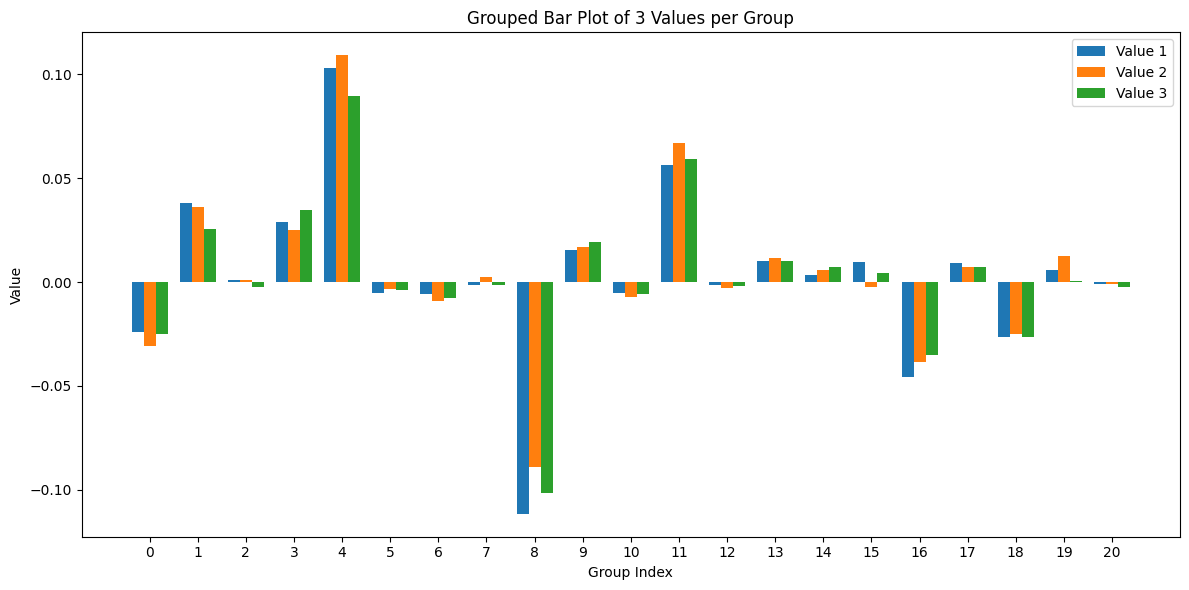

In [196]:
data = np.array(shap_values)
num_groups = len(data)
num_bars = data.shape[1]

x = np.arange(num_groups)  # positions for groups
bar_width = 0.25

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each of the 3 bars per group
for i in range(num_bars):
    ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=f'Value {i + 1}')

# Styling
ax.set_xlabel('Group Index')
ax.set_ylabel('Value')
ax.set_title('Grouped Bar Plot of 3 Values per Group')
ax.set_xticks(x + bar_width)
ax.set_xticklabels([str(i) for i in range(num_groups)])
ax.legend()

plt.tight_layout()
plt.show()

## KernelExplainer

In [197]:
explainer = shap.KernelExplainer(wrapped_model, background_numpy)

In [129]:
random_state = torch.stack(random.sample(non_replay_buffer_states, k=1)).numpy()
print(random_state)

[[ 0.          1.          0.          1.          2.         -0.
  -1.          3.          2.          0.          1.          2.236068
   0.44721356  0.89442724 -0.89442724 -0.4472135   3.6055512   0.8320503
   0.5547002   0.5547002   0.8320503 ]]


In [199]:
random_state = random_state.numpy()

In [203]:
shap_values = explainer.shap_values(random_state)[0]

  0%|          | 0/1 [00:00<?, ?it/s]

In [204]:
print(shap_values)

[[-0.02674447 -0.02634907 -0.02859997]
 [ 0.03298224  0.03106649  0.        ]
 [ 0.          0.          0.        ]
 [ 0.03297574  0.01826375  0.03629241]
 [ 0.1012337   0.09453418  0.08848834]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.11882676 -0.10423776 -0.10388354]
 [ 0.0193686   0.01500316  0.02111525]
 [ 0.          0.          0.        ]
 [ 0.05833752  0.06078635  0.06042832]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.00888523]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.0483261  -0.04053827 -0.02893325]
 [ 0.01236833  0.          0.00733397]
 [-0.02393883 -0.02374849 -0.02573726]
 [ 0.          0.01174684  0.        ]
 [ 0.          0.          0.        ]]


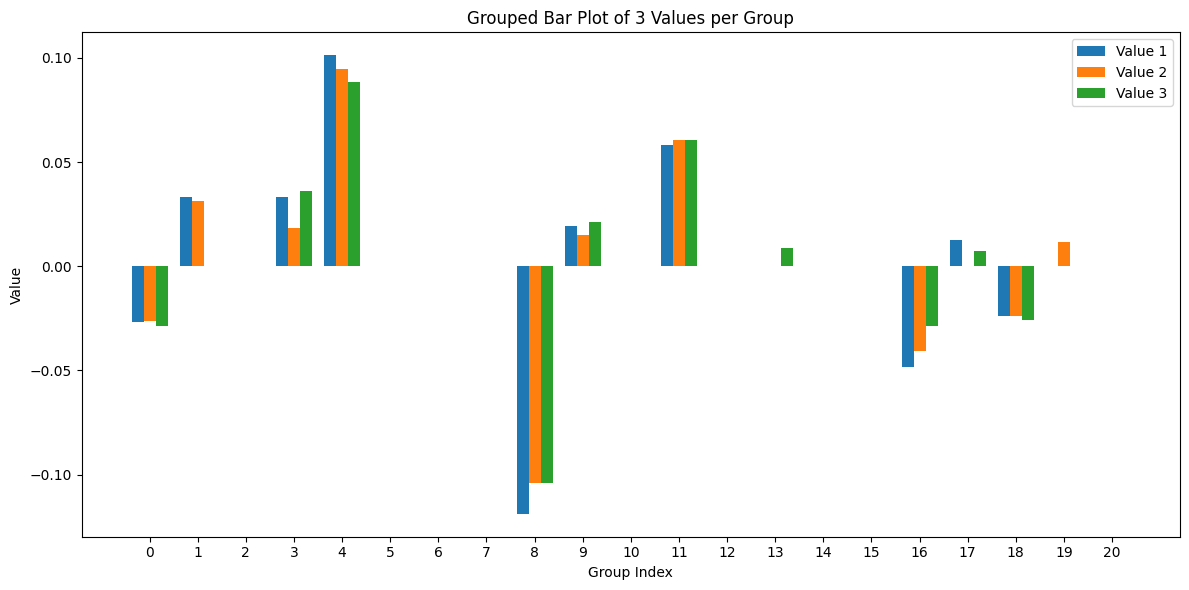

In [205]:
data = np.array(shap_values)
num_groups = len(data)
num_bars = data.shape[1]

x = np.arange(num_groups)  # positions for groups
bar_width = 0.25

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each of the 3 bars per group
for i in range(num_bars):
    ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=f'Value {i + 1}')

# Styling
ax.set_xlabel('Group Index')
ax.set_ylabel('Value')
ax.set_title('Grouped Bar Plot of 3 Values per Group')
ax.set_xticks(x + bar_width)
ax.set_xticklabels([str(i) for i in range(num_groups)])
ax.legend()

plt.tight_layout()
plt.show()